In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from IPython.display import clear_output

np.random.seed(99)

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [4]:
# Functions related to positioning and distances

def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions


def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')


def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.sqrt(((ue_pos[ue])[0] - (ap_pos[ap])[0])**2
                          + ((ue_pos[ue])[1] - (ap_pos[ap])[1])**2)

            if dis >= ref_distance:
                dis_matrix[ue, ap] = dis
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [5]:
def fpc_algorithm(path_loss, max_power, noise_power, compesation_factor, SNR):
    target_power  = SNR + noise_power + 30
    optimal_power = np.zeros((path_loss.shape[0]))

    for i in range(path_loss.shape[0]):
        beta = np.outer(path_loss[i:], path_loss[i,:].T)
        optimal_power[i] = np.min([max_power, db2lin(target_power) * (np.sqrt(np.trace(beta))) ** (-compesation_factor)])

    return optimal_power

In [6]:
def stepwise_removal(gain_matrix, distance_mat, SINR=0):

    power_vector = np.zeros(gain_matrix.shape[0])

    
    matrix_Z = np.zeros((gain_matrix.shape[0], gain_matrix.shape[0]))
    gain_array = np.zeros(gain_matrix.shape[0])
    
    aux_gain_matrix = copy.deepcopy(gain_matrix)
    new_matrix_Z = np.zeros((gain_matrix.shape[0], gain_matrix.shape[0]))
    
    for i in range(gain_matrix.shape[0]):
        gain_array[i] = sum(gain_matrix[i])

    for i in range(gain_matrix.shape[0]):
        matrix_Z[i] = gain_array / gain_array[i]
    
    target_SINR = db2lin(SINR) 
    aux_matrix_Z = copy.deepcopy(matrix_Z)
    
    #while True:

    eigenvalues_matrix = np.linalg.eig(matrix_Z)[0]
    eigenvector_matrix = np.linalg.eig(matrix_Z)[1]
    
    max_eigenvalue = eigenvalues_matrix.max()
    index = np.where(eigenvalues_matrix == max_eigenvalue)
    
    max_eigenvector = eigenvector_matrix[index] 
    
    max_achievable_SINR = 1 / (max_eigenvalue - 1)
    
    power_vector = max_eigenvector
        #for p in range(max_eigenvector[0].shape[0]):
        #    power_vector[p] = max_eigenvector[0][p]
        #power_vector = np.where(power_vector==0, max_eigenvector[0][0], power_vector)
        # break
        
        # else:

        #     # Remove the better link 
        #     max_value = float('-inf')
        #     max_j = 0

        #     for j in range(matrix_Z.shape[0]):
             
        #         soma = sum(matrix_Z[j]) + sum(np.transpose(matrix_Z)[j])

        #         if soma > max_value:
        #             max_value = soma
        #             max_j = j

        #     new_matrix_Z[max_j] = aux_matrix_Z[max_j]
            
        #     matrix_Z = np.delete(matrix_Z, max_j, 0)
        #     matrix_Z = np.delete(matrix_Z, max_j, 1) 
            
        #     #aux_gain_matrix = np.delete(aux_gain_matrix, max_j, 0)
            
        #     distance_mat = np.delete(distance_mat, max_j, 0)

    
    return power_vector, max_achievable_SINR # , distance_mat

In [7]:
def gain(hor_distance, shadow):
    
    return db2lin(- shadow - 30.5 -36.7*np.log10(np.sqrt(hor_distance**2 + 10**2)))

In [8]:
# Functions related to channel modeling

def snr_cellfree(hor_distance, power):

    return db2lin(- 2*np.random.randn() + power + 96 - 30.5 -36.7*np.log10(np.sqrt(hor_distance**2 + 10**2)))

def channel_gain(snr):

    channel_matrix = np.zeros(snr.shape)
    for ue in range(snr.shape[0]):
        channel_matrix[ue,:] = np.sqrt(snr[ue, :])
        
    return channel_matrix

In [9]:
# def mmse_sinr(channel_m):

#     M = channel_m.shape[1]
#     sinr = np.zeros(channel_m.shape[0])
#     sum = 0
    
#     for ue in range(channel_m.shape[0]):
        
#         sum += channel_m[ue] @ channel_m[ue].T
        
#     for ue in range(channel_m.shape[0]):
         
#         sinr[ue] = channel_m[ue].T @ np.linalg.inv(sum - channel_m[ue] @ channel_m[ue].T + np.eye(M)) @ channel_m[ue]
        
#     return sinr

In [10]:
def sinr_mmse(channel):

    sinr = np.zeros(channel.shape[0])
    sum = 0
    
    for ue in range(channel.shape[0]):

        sum += np.outer(channel[ue, :], channel[ue, :].T)
    
    for ue in range(channel.shape[0]):

        desired = channel[ue, :]

        sinr[ue] = desired.T @ np.linalg.inv(sum - np.outer(desired, desired.T) + np.eye(channel.shape[1])) @ desired

    return sinr

In [11]:
def simulation(ue_quantity):

    num_ue = ue_quantity
    num_ap = 64
    cov_side = 400 # [m]
    seeds = 100
    noise_gain = 1e-20 * 100e6 * db2lin(6)
    noise_p = -96 # [dBm]
    max_power = dbm2lin(30)
    
    total_sinr_mp = np.zeros((num_ue, seeds))
    total_sinr_fpc = np.zeros((num_ue, seeds))
    total_sinr_sra = []
    
    total_power_mp = np.zeros(seeds)
    total_power_fpc = np.zeros(seeds)
    total_power_sra = np.zeros(seeds)

    total_target_sinr = np.zeros(seeds)
    
    for seed in range(seeds):
    
        ue_pos = random_ue_positions(num_ue, cov_side)
        ap_pos = ap_positions(num_ap, cov_side)
        distances = distance(ue_pos, ap_pos)
        
        
        shadowing = 2*np.random.randn(num_ue, num_ap)
        gains = gain(distances, shadowing)
        
        
        # Max Power
        power_mp = np.ones((num_ue, num_ap)) * max_power
        
         # Stepwise Removal Algorithm
        sra = stepwise_removal(gains, distances, 0)
        power_sra = np.real(np.abs(sra[0]))
        #distances_sra = sra[1]
    
        sra_matrix = np.ones((num_ue, num_ap))
        
        for row in range(num_ue):
            
            sra_matrix[row] = sra_matrix[row] * power_sra[0][row]
        
        # Fractional Power Control
        power_fpc = fpc_algorithm(gains, max_power, noise_p, 0.8, np.real(sra[1]))
        fpc_matrix = np.ones((num_ue, num_ap))
    
        for row in range(num_ue):
            
            fpc_matrix[row] = fpc_matrix[row] * power_fpc[row]  
    
            
        snr_mp = snr_cellfree(distances, lin2db(power_mp)) 
        snr_fpc = snr_cellfree(distances, lin2db(fpc_matrix))
        snr_sra = snr_cellfree(distances, lin2db(sra_matrix))
        
        channels_mp = channel_gain(snr_mp)
        channels_fpc = channel_gain(snr_fpc)
        channels_sra = channel_gain(snr_sra)
        
        total_power_mp[seed] = num_ue
        total_power_fpc[seed] = sum(power_fpc)
        total_power_sra[seed] = sum(power_sra[0])

        total_target_sinr[seed] = sra[1] 
        
        # print(power_sra.shape)
        # print('seed: ', seed)
        clear_output(wait=True)
        
        for ue in range(num_ue):
            total_sinr_mp[:, seed] = lin2db(sinr_mmse(channels_mp))
            total_sinr_fpc[:, seed] = lin2db(sinr_mmse(channels_fpc))
        
        for ch in range(power_sra.shape[0]):
            total_sinr_sra = np.concatenate((total_sinr_sra, lin2db(sinr_mmse(channels_sra))))
    
    return total_sinr_mp, total_sinr_fpc, total_sinr_sra, total_power_mp, total_power_fpc, total_power_sra, total_target_sinr
    #return channels_mp, channels_fpc, channels_sra

In [12]:
# Simulations for different number of UEs

simulation_2 = simulation(2)
simulation_4 = simulation(4)
simulation_8 = simulation(8)
simulation_16 = simulation(16)
simulation_32 = simulation(32)
simulation_64 = simulation(64)

/tmp/ipykernel_25031/3411889324.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  total_target_sinr[seed] = sra[1]


[ 1  5  9 13 17 21]


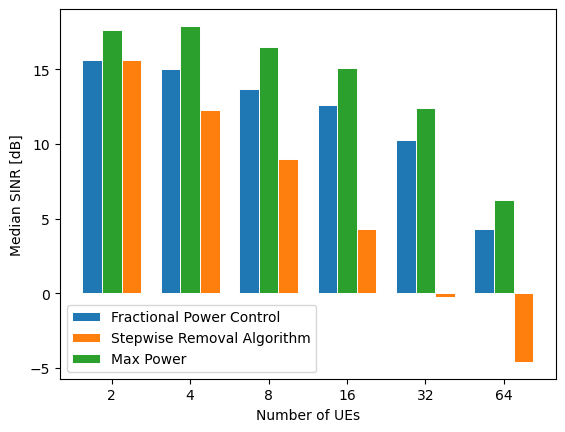

In [13]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

mp_sinr_medians = np.array([
    np.median(simulation_2[0]),
    np.median(simulation_4[0]),
    np.median(simulation_8[0]),
    np.median(simulation_16[0]),
    np.median(simulation_32[0]),
    np.median(simulation_64[0]),
])

fpc_sinr_medians = np.array([
    np.median(simulation_2[1]),
    np.median(simulation_4[1]),
    np.median(simulation_8[1]),
    np.median(simulation_16[1]),
    np.median(simulation_32[1]),
    np.median(simulation_64[1]),
])

sra_sinr_medians = np.array([
    np.median(simulation_2[2]),
    np.median(simulation_4[2]),
    np.median(simulation_8[2]),
    np.median(simulation_16[2]),
    np.median(simulation_32[2]),
    np.median(simulation_64[2]),
])

xs = np.array([
    np.arange(23, step=4),
    np.arange(1, 23, step=4),
    np.arange(2, 23, step=4),
])

ax.bar(xs[0], fpc_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Fractional Power Control')
ax.bar(xs[2], sra_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Stepwise Removal Algorithm')
ax.bar(xs[1], mp_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Max Power')

x_labels = ['2', '4', '8', '16', '32', '64']
ax.set_ylabel('Median SINR [dB]')
ax.set_xlabel('Number of UEs')
print(xs[1])
ax.set_xticks(xs[1], x_labels)
ax.legend(loc='lower left')

plt.savefig('SINR_graphbar_SBrT2024.pdf')

In [14]:
print('2 UEs', 100 * (np.median(db2lin(simulation_2[2])) - np.median(db2lin(simulation_2[1]))) / np.median(db2lin(simulation_2[2])))
print('4 UEs', 100 * (np.median(db2lin(simulation_4[2])) - np.median(db2lin(simulation_4[1]))) / np.median(db2lin(simulation_4[2])))
print('8 UEs', 100 * (np.median(db2lin(simulation_8[2])) - np.median(db2lin(simulation_8[1]))) / np.median(db2lin(simulation_8[2])))
print('16 UEs', 100 * (np.median(db2lin(simulation_16[2])) - np.median(db2lin(simulation_16[1]))) / np.median(db2lin(simulation_16[2])))
print('32 UEs', 100 * (np.median(db2lin(simulation_32[2])) - np.median(db2lin(simulation_32[1]))) / np.median(db2lin(simulation_32[2])))
print('64 UEs', 100 * (np.median(db2lin(simulation_64[2])) - np.median(db2lin(simulation_64[1]))) / np.median(db2lin(simulation_64[2])))

2 UEs 1.155838156433429
4 UEs -89.71796619576855
8 UEs -192.09428507699295
16 UEs -579.3355330048564
32 UEs -1023.8884528377689
64 UEs -673.3108737748389


[ 1  5  9 13 17 21]


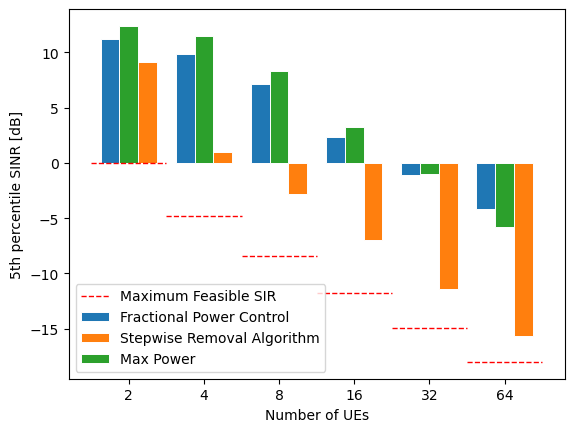

In [30]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

mp_sinr_medians = np.array([
    np.percentile(simulation_2[0], 5),
    np.percentile(simulation_4[0], 5),
    np.percentile(simulation_8[0], 5),
    np.percentile(simulation_16[0], 5),
    np.percentile(simulation_32[0], 5),
    np.percentile(simulation_64[0], 5),
])

fpc_sinr_medians = np.array([
    np.percentile(simulation_2[1], 5),
    np.percentile(simulation_4[1], 5),
    np.percentile(simulation_8[1], 5),
    np.percentile(simulation_16[1], 5),
    np.percentile(simulation_32[1], 5),
    np.percentile(simulation_64[1], 5),
])

sra_sinr_medians = np.array([
    np.percentile(simulation_2[2], 5),
    np.percentile(simulation_4[2], 5),
    np.percentile(simulation_8[2], 5),
    np.percentile(simulation_16[2], 5),
    np.percentile(simulation_32[2], 5),
    np.percentile(simulation_64[2], 5),
])

xs = np.array([
    np.arange(23, step=4),
    np.arange(1, 23, step=4),
    np.arange(2, 23, step=4),
])

ax.bar(xs[0], fpc_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Fractional Power Control')
ax.bar(xs[2], sra_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Stepwise Removal Algorithm')
ax.bar(xs[1], mp_sinr_medians, width=1, edgecolor="white", linewidth=0.7, label='Max Power')

ax.hlines(y=0.0, xmin=-1, xmax=3, colors='red', linestyles='dashed', linewidth=1, label='Maximum Feasible SIR')
ax.hlines(y=-4.771212547196623, xmin=3, xmax=7, colors='red', linestyles='dashed', linewidth=1)
ax.hlines(y=-8.45098040014257, xmin=7, xmax=11, colors='red', linestyles='dashed', linewidth=1)
ax.hlines(y=-11.760912590556813, xmin=11, xmax=15, colors='red', linestyles='dashed', linewidth=1)
ax.hlines(y=-14.913616938342727, xmin=15, xmax=19, colors='red', linestyles='dashed', linewidth=1)
ax.hlines(y=-17.993405494535818, xmin=19, xmax=23, colors='red', linestyles='dashed', linewidth=1)

x_labels = ['2', '4', '8', '16', '32', '64']
ax.set_ylabel('5th percentile SINR [dB]')
ax.set_xlabel('Number of UEs')
print(xs[1])
ax.set_xticks(xs[1], x_labels)
ax.legend(loc='lower left')


plt.savefig('5thSINR_graphbar_SBrT2024.pdf')

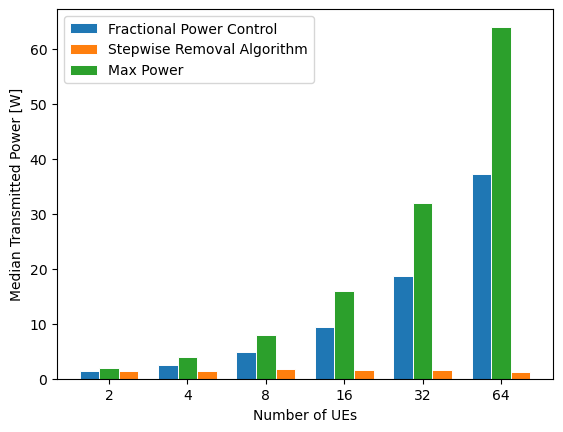

In [16]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

mp_pow_medians = np.array([
    np.median(simulation_2[3]),
    np.median(simulation_4[3]),
    np.median(simulation_8[3]),
    np.median(simulation_16[3]),
    np.median(simulation_32[3]),
    np.median(simulation_64[3]),
])

fpc_pow_medians = np.array([
    np.median(simulation_2[4]),
    np.median(simulation_4[4]),
    np.median(simulation_8[4]),
    np.median(simulation_16[4]),
    np.median(simulation_32[4]),
    np.median(simulation_64[4]),
])

sra_pow_medians = np.array([
    np.median(simulation_2[5]),
    np.median(simulation_4[5]),
    np.median(simulation_8[5]),
    np.median(simulation_16[5]),
    np.median(simulation_32[5]),
    np.median(simulation_64[5]),
])

xs = np.array([
    np.arange(23, step=4),
    np.arange(1, 23, step=4),
    np.arange(2, 23, step=4),
])

ax.bar(xs[0], fpc_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Fractional Power Control')
ax.bar(xs[2], sra_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Stepwise Removal Algorithm')
ax.bar(xs[1], mp_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Max Power')

x_labels = ['2', '4', '8', '16', '32', '64']
ax.set_ylabel('Median Transmitted Power [W]')
ax.set_xlabel('Number of UEs')
ax.set_xticks(xs[1], x_labels)
ax.legend(loc='upper left')

plt.savefig('Capacity_graphbar_SBrT2024.pdf')

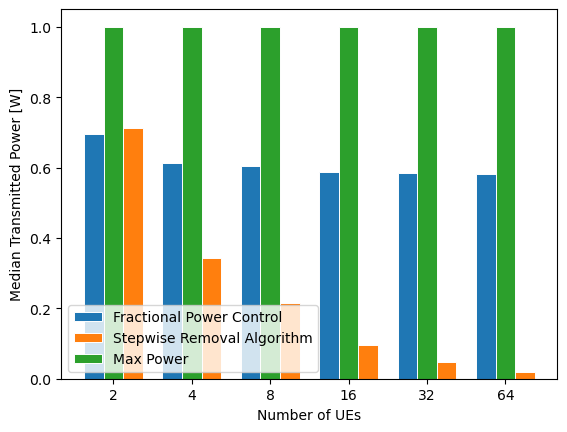

In [17]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

mp_pow_medians = np.array([
    np.median(simulation_2[3]) / np.median(simulation_2[3]),
    np.median(simulation_4[3]) / np.median(simulation_4[3]),
    np.median(simulation_8[3]) / np.median(simulation_8[3]),
    np.median(simulation_16[3]) / np.median(simulation_16[3]),
    np.median(simulation_32[3]) / np.median(simulation_32[3]),
    np.median(simulation_64[3]) / np.median(simulation_64[3]),
])

fpc_pow_medians = np.array([
    np.median(simulation_2[4]) / np.median(simulation_2[3]),
    np.median(simulation_4[4]) / np.median(simulation_4[3]),
    np.median(simulation_8[4]) / np.median(simulation_8[3]),
    np.median(simulation_16[4]) / np.median(simulation_16[3]),
    np.median(simulation_32[4]) / np.median(simulation_32[3]),
    np.median(simulation_64[4]) / np.median(simulation_64[3]),
])

sra_pow_medians = np.array([
    np.median(simulation_2[5]) / np.median(simulation_2[3]),
    np.median(simulation_4[5]) / np.median(simulation_4[3]),
    np.median(simulation_8[5]) / np.median(simulation_8[3]),
    np.median(simulation_16[5]) / np.median(simulation_16[3]),
    np.median(simulation_32[5]) / np.median(simulation_32[3]),
    np.median(simulation_64[5]) / np.median(simulation_64[3]),
])

xs = np.array([
    np.arange(23, step=4),
    np.arange(1, 23, step=4),
    np.arange(2, 23, step=4),
])

ax.bar(xs[0], fpc_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Fractional Power Control')
ax.bar(xs[2], sra_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Stepwise Removal Algorithm')
ax.bar(xs[1], mp_pow_medians, width=1, edgecolor="white", linewidth=0.7, label='Max Power')

x_labels = ['2', '4', '8', '16', '32', '64']
ax.set_ylabel('Median Transmitted Power [W]')
ax.set_xlabel('Number of UEs')
ax.set_xticks(xs[1], x_labels)
ax.legend(loc='lower left')

plt.savefig('normalized_tpower_graphbar_SBrT2024.pdf')

In [18]:
print('2 UEs', 100 * (np.median(simulation_2[5]) - np.median(simulation_2[4])) / np.median(simulation_2[5]))
print('4 UEs', 100 * (np.median(simulation_4[5]) - np.median(simulation_4[4])) / np.median(simulation_4[5]))
print('8 UEs', 100 * (np.median(simulation_8[5]) - np.median(simulation_8[4])) / np.median(simulation_8[5]))
print('16 UEs', 100 * (np.median(simulation_16[5]) - np.median(simulation_16[4])) / np.median(simulation_16[5]))
print('32 UEs', 100 * (np.median(simulation_32[5]) - np.median(simulation_32[4])) / np.median(simulation_32[5]))
print('64 UEs', 100 * (np.median(simulation_64[5]) - np.median(simulation_64[4])) / np.median(simulation_64[5]))

2 UEs 2.3155533760691456
4 UEs -78.69594052761859
8 UEs -181.13356568629646
16 UEs -514.8761300015386
32 UEs -1115.131188729021
64 UEs -3179.3052184912417


In [19]:
print('SINR target: ', lin2db(np.mean(simulation_2[6])))
print('SINR target: ', lin2db(np.mean(simulation_4[6])))
print('SINR target: ', lin2db(np.mean(simulation_8[6])))
print('SINR target: ', lin2db(np.mean(simulation_16[6])))
print('SINR target: ', lin2db(np.mean(simulation_32[6])))
print('SINR target: ', lin2db(np.mean(simulation_64[6])))

SINR target:  0.0
SINR target:  -4.771212547196623
SINR target:  -8.45098040014257
SINR target:  -11.760912590556813
SINR target:  -14.913616938342727
SINR target:  -17.993405494535818


In [20]:
np.percentile(simulation_64[2], 5)

-15.61259569710285